In [1]:
import numpy as np
import pandas as pd
import datetime
import geopandas as gpd
pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.options.display.float_format = '{:.5f}'.format
import warnings
warnings.filterwarnings("ignore")
# %pip install contextily

import matplotlib.colors as mcolors
from shapely.geometry import Point
from geopandas import GeoDataFrame

In [2]:
%%time
df_shap = pd.read_csv("./output/food_localness_final_oct_new_shap_values.csv", sep=",", header=0)
df_shap = df_shap.drop(columns=['account_id','customer_lon','customer_lat','vendor_id','vendor_lon','vendor_lat'])
print(df_shap.shape[0])

df_localness = pd.read_csv('./data/food_localness_final_oct_new.csv')
print(df_localness.shape[0])

df_shap.head()

2782961
CPU times: user 13.5 s, sys: 1.16 s, total: 14.7 s
Wall time: 17.8 s


,order_id,shap_customer_lon,shap_customer_lat,shap_basket_amount_lc,shap_price_per_item,shap_order_time_hour,shap_total_duration,shap_estimated_rent,shap_entropy_0.5km,shap_entropy_2km,shap_entropy_5km,shap_incentive_amount_lc,shap_incentive_delivery,shap_incentive_menu_discount,shap_incentive_voucher_wallet,shap_main_cuisine,shap_isweekend,shap_consistency,shap_total_orders,shap_rating,shap_n_rating,shap_restaurant_count_0.5km,shap_restaurant_count_0.5_1km,shap_restaurant_count_1_2km,shap_restaurant_count_2_3km,shap_restaurant_count_3_4km,shap_restaurant_count_4_5km
0,1304769890,-0.00700,-0.01416,-0.01049,-0.03658,0.05246,-0.05788,-0.01585,0.00036,-0.00766,0.00060,0.01495,-0.00232,0.01096,0.00100,-0.02045,0.00069,0.00302,-0.00381,-0.00390,0.00393,-0.07875,-0.01005,0.01626,-0.02434,0.00044,-0.00006
1,1304769334,0.00155,-0.01932,-0.00655,-0.03077,0.05136,-0.03860,-0.01359,-0.01035,-0.00673,0.00457,0.01726,-0.00001,0.00937,0.00102,-0.00446,-0.00003,-0.00126,-0.00231,0.01493,0.00445,-0.06185,-0.01068,0.00895,-0.01686,0.00066,-0.00035
2,1306219965,-0.01347,-0.02119,0.00027,0.02538,0.03483,0.01954,-0.01046,-0.00508,-0.01530,-0.00191,-0.00811,0.00005,-0.01162,-0.00086,0.00638,-0.00073,-0.00293,-0.00914,0.00652,0.02472,-0.08642,-0.00981,-0.00867,-0.00991,-0.00350,-0.00520
3,1295994041,-0.01150,-0.02168,-0.00094,0.02542,0.03613,0.05872,-0.01017,-0.00242,-0.01868,-0.00022,-0.00852,0.00004,-0.00976,-0.00056,0.01619,-0.00055,-0.00360,-0.00835,0.01021,0.02568,-0.09305,-0.01366,-0.00944,-0.00957,-0.00265,-0.00616
4,1304742536,-0.00545,-0.02307,-0.00619,-0.01789,0.02276,-0.02453,-0.00766,-0.03050,-0.01598,0.00167,0.02036,-0.00529,0.00153,0.00001,-0.01623,0.00070,-0.00121,-0.00197,-0.04450,-0.02838,-0.06445,-0.00714,-0.01947,-0.00973,-0.00985,-0.02598


In [4]:
df_shap_merged = df_localness.merge(df_shap, on='order_id')
print(df_shap_merged.shape[0])

2782961


In [11]:
selected_feature = 'estimated_rent'
# Some continuous features to be considered: estimated_rent, incentive_amount_lc, entropy_0.5km, restaurant_count_0.5km,
# price_per_item, order_time_hour, basket_amount_lc, total_orders, consistency, incentive_delivery
# incentive_menu_discount, incentive_voucher_wallet

benchmark = df_shap_merged[selected_feature].median()
df_shap_need = df_shap_merged[[selected_feature,'shap_'+selected_feature]]
df_shap_need.loc[(df_shap_need[selected_feature]>=benchmark) & (df_shap_need['shap_'+selected_feature]>0),'Quadrant'] = 'High-Positive'
df_shap_need.loc[(df_shap_need[selected_feature]>=benchmark) & (df_shap_need['shap_'+selected_feature]<=0),'Quadrant'] = 'High-Negative'
df_shap_need.loc[(df_shap_need[selected_feature]<benchmark) & (df_shap_need['shap_'+selected_feature]>0),'Quadrant'] = 'Low-Positive'
df_shap_need.loc[(df_shap_need[selected_feature]<benchmark) & (df_shap_need['shap_'+selected_feature]<=0),'Quadrant'] = 'Low-Negative'
print(df_shap_need.Quadrant.value_counts())

Low-Negative     884703
High-Negative    699468
High-Positive    692016
Low-Positive     506774
Name: Quadrant, dtype: int64
CPU times: user 349 ms, sys: 44.9 ms, total: 394 ms
Wall time: 333 ms


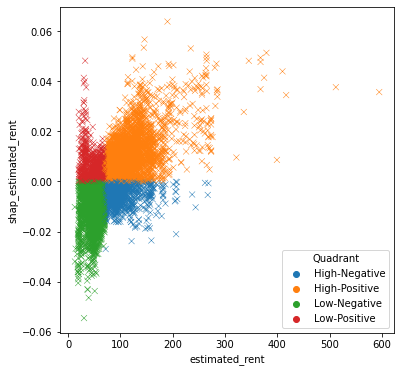

CPU times: user 450 ms, sys: 97.2 ms, total: 547 ms
Wall time: 382 ms


In [20]:
%%time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_shap_need.head(10000), 
                x=selected_feature, 
                y='shap_'+selected_feature, 
                hue="Quadrant", 
                marker='x')  # Use marker='x' here
plt.show()

# Hexagon - best visualization for 2 million points

,index,geometry
h3_polyfill,,
8843a139e9fffff,0,"POLYGON ((55.17186 24.88708, 55.17361 24.88281, 55.17870 24.88168, 55.18202 24.88483, 55.18026 24.88911, 55.17518 24.89023, 55.17186 24.88708))"
8843acd85bfffff,0,"POLYGON ((55.22398 25.32372, 55.22575 25.31942, 55.23086 25.31830, 55.23421 25.32147, 55.23244 25.32577, 55.22733 25.32689, 55.22398 25.32372))"
8843acc8a7fffff,0,"POLYGON ((55.45144 25.22277, 55.45320 25.21847, 55.45831 25.21734, 55.46167 25.22050, 55.45991 25.22480, 55.45480 25.22593, 55.45144 25.22277))"
8843acc915fffff,0,"POLYGON ((55.38737 25.18613, 55.38913 25.18184, 55.39424 25.18071, 55.39759 25.18388, 55.39583 25.18817, 55.39073 25.18930, 55.38737 25.18613))"
8843a1ae39fffff,0,"POLYGON ((55.06399 25.24942, 55.06576 25.24513, 55.07087 25.24401, 55.07420 25.24718, 55.07243 25.25147, 55.06732 25.25259, 55.06399 25.24942))"


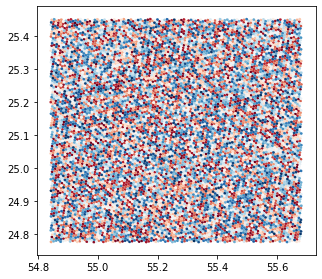

In [21]:
from shapely.geometry import box

bound_lat = [24.776468,25.451666]
bound_lon = [54.842954,55.680861] # 25.637066, 55.849584 

dubai_box = gpd.GeoDataFrame(geometry=[box(bound_lon[0],bound_lat[0],bound_lon[1],bound_lat[1])],crs="EPSG:4326")
# %pip install h3pandas
# create hexagon within the UAE border
import geopandas as gpd
import h3pandas

resolution = 8 # Average edge length: 500m
hexagons = dubai_box.h3.polyfill_resample(resolution)
ax = hexagons.plot(figsize=(5, 5), cmap='RdBu')
hexagons.head()

In [32]:
%%time

selected_feature = 'incentive_amount_lc'
# Some continuous features to be considered: estimated_rent, incentive_amount_lc, entropy_0.5km, restaurant_count_0.5km,
# price_per_item, order_time_hour, basket_amount_lc, total_orders, consistency, incentive_delivery
# incentive_menu_discount, incentive_voucher_wallet
df_onefeature = df_shap_merged[['account_id','order_id','customer_lon','customer_lat', selected_feature,'shap_'+selected_feature]]
# df_onefeature = df_onefeature[df_onefeature['incentive_amount_lc']<=10]
geometry2 = [Point(xy) for xy in zip(df_onefeature.customer_lon, df_onefeature.customer_lat)]
gdf_onefeature = GeoDataFrame(df_onefeature, crs="EPSG:4326", geometry=geometry2)
# gdf_test = gdf_onefeature.head(1000)
# gdf_test.head()

CPU times: user 17.4 s, sys: 87.7 ms, total: 17.5 s
Wall time: 17.5 s


In [33]:
%%time
mean_hex = gpd.sjoin(gdf_onefeature, hexagons, op='within') 
hexagon_agg = mean_hex[['index_right',selected_feature,'shap_'+selected_feature]].groupby('index_right').agg('mean')
hexagon_agg_ordernumber = hexagons.merge(hexagon_agg,left_index=True,right_index=True) # focus on hexagons that contains delivery data
print(hexagon_agg_ordernumber.shape[0])
hexagon_agg_ordernumber.head()

1351
CPU times: user 4.75 s, sys: 968 ms, total: 5.72 s
Wall time: 5.72 s


,index,geometry,incentive_amount_lc,shap_incentive_amount_lc
8843acc8a7fffff,0,"POLYGON ((55.45144 25.22277, 55.45320 25.21847, 55.45831 25.21734, 55.46167 25.22050, 55.45991 25.22480, 55.45480 25.22593, 55.45144 25.22277))",7.59000,-0.00123
8843acc915fffff,0,"POLYGON ((55.38737 25.18613, 55.38913 25.18184, 55.39424 25.18071, 55.39759 25.18388, 55.39583 25.18817, 55.39073 25.18930, 55.38737 25.18613))",6.43546,-0.00120
8843a13005fffff,0,"POLYGON ((55.12149 25.06536, 55.12326 25.06108, 55.12835 25.05996, 55.13168 25.06312, 55.12991 25.06740, 55.12482 25.06852, 55.12149 25.06536))",8.75563,-0.00206
8843a12459fffff,0,"POLYGON ((55.39678 25.11768, 55.39853 25.11339, 55.40363 25.11226, 55.40698 25.11542, 55.40523 25.11971, 55.40013 25.12084, 55.39678 25.11768))",0.00000,-0.00140
8843a12269fffff,0,"POLYGON ((55.20476 25.04314, 55.20652 25.03886, 55.21162 25.03774, 55.21495 25.04090, 55.21319 25.04518, 55.20810 25.04630, 55.20476 25.04314))",9.56744,-0.00238


In [139]:
# hexagon_agg_ordernumber[selected_feature].describe()
# df_shap_merged[selected_feature].median()

In [34]:
feature_mean = hexagon_agg_ordernumber[selected_feature].median()
# feature_mean = hexagon_agg_ordernumber[hexagon_agg_ordernumber[selected_feature]!=0][selected_feature].median()
print('feature median values:',feature_mean)
shap_threshold = 0.00
# df_onefeature = df_onefeature.groupby(['account_id','customer_lon','customer_lat'])[[selected_feature,'shap_'+selected_feature]].mean().reset_index()
# df_onefeature['Quadrant'] = 'NaN'
hexagon_agg_ordernumber.loc[(hexagon_agg_ordernumber[selected_feature]>=feature_mean) & (hexagon_agg_ordernumber['shap_'+selected_feature]>shap_threshold),'Quadrant'] = 'High-Positive'
hexagon_agg_ordernumber.loc[(hexagon_agg_ordernumber[selected_feature]>=feature_mean) & (hexagon_agg_ordernumber['shap_'+selected_feature]<=-1*shap_threshold),'Quadrant'] = 'High-Negative'
hexagon_agg_ordernumber.loc[(hexagon_agg_ordernumber[selected_feature]<feature_mean) & (hexagon_agg_ordernumber['shap_'+selected_feature]>shap_threshold),'Quadrant'] = 'Low-Positive'
hexagon_agg_ordernumber.loc[(hexagon_agg_ordernumber[selected_feature]<feature_mean) & (hexagon_agg_ordernumber['shap_'+selected_feature]<=-1*shap_threshold),'Quadrant'] = 'Low-Negative'
print(hexagon_agg_ordernumber.Quadrant.value_counts())
hexagon_agg_ordernumber.head()

feature median values: 6.892879683109664
High-Negative    521
Low-Positive     407
Low-Negative     268
High-Positive    155
Name: Quadrant, dtype: int64


,index,geometry,incentive_amount_lc,shap_incentive_amount_lc,Quadrant
8843acc8a7fffff,0,"POLYGON ((55.45144 25.22277, 55.45320 25.21847, 55.45831 25.21734, 55.46167 25.22050, 55.45991 25.22480, 55.45480 25.22593, 55.45144 25.22277))",7.59000,-0.00123,High-Negative
8843acc915fffff,0,"POLYGON ((55.38737 25.18613, 55.38913 25.18184, 55.39424 25.18071, 55.39759 25.18388, 55.39583 25.18817, 55.39073 25.18930, 55.38737 25.18613))",6.43546,-0.00120,Low-Negative
8843a13005fffff,0,"POLYGON ((55.12149 25.06536, 55.12326 25.06108, 55.12835 25.05996, 55.13168 25.06312, 55.12991 25.06740, 55.12482 25.06852, 55.12149 25.06536))",8.75563,-0.00206,High-Negative
8843a12459fffff,0,"POLYGON ((55.39678 25.11768, 55.39853 25.11339, 55.40363 25.11226, 55.40698 25.11542, 55.40523 25.11971, 55.40013 25.12084, 55.39678 25.11768))",0.00000,-0.00140,Low-Negative
8843a12269fffff,0,"POLYGON ((55.20476 25.04314, 55.20652 25.03886, 55.21162 25.03774, 55.21495 25.04090, 55.21319 25.04518, 55.20810 25.04630, 55.20476 25.04314))",9.56744,-0.00238,High-Negative


incentive_amount_lc


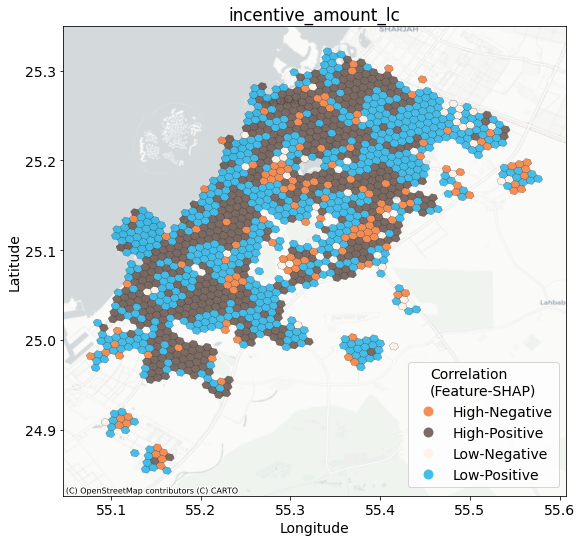

CPU times: user 874 ms, sys: 96.6 ms, total: 971 ms
Wall time: 803 ms


In [30]:
%%time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import contextily as cx

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, figsize=(9, 9))
print(selected_feature)
# High-Negative, High-Positive, Low-Negative, Low-Positive
colorlist = ['#f3742e','#5c473e', '#fef1e4','#18aee5']
cmap = mcolors.ListedColormap(colorlist)

hexagon_agg_ordernumber.plot(
    column='Quadrant',         # Categorical column
    cmap=cmap,               # Colormap for categories
    alpha=0.8,
    legend=True,               # Show legend for categories
    categorical=True,          # Specify that the column is categorical
#     markersize= gdf_onefeature[selected_feature]/5,
    edgecolor = 'black',
    linewidth=0.2,
    ax=ax
)

leg = ax.get_legend()
leg.set_bbox_to_anchor((1,0.3))
leg.set_title('Correlation\n(Feature-SHAP)')
cx.add_basemap(ax, crs=gdf_onefeature.crs, source=cx.providers.CartoDB.Positron)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(selected_feature)
# plt.savefig('./output/hex_spatial_SHAP_'+selected_feature+'.png', dpi=300, bbox_inches='tight')
plt.show()

# Second vis way: Interactive map

In [5]:
# select a sample to speed up
df_shap_merged_test = df_shap_merged.head(10000)
df_shap_merged_test = df_shap_merged_test[['order_id','customer_lon','customer_lat','estimated_rent','shap_estimated_rent']]

#Converting Pandas DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(df_shap_merged_test.customer_lon, df_shap_merged_test.customer_lat)]
gdf = GeoDataFrame(df_shap_merged_test, crs="EPSG:4326", geometry=geometry)

In [6]:
benchmark = gdf['estimated_rent'].median()
gdf.loc[(gdf['estimated_rent']>=benchmark) & (gdf['shap_estimated_rent']>0),'Quadrant'] = 'High-Positive'
gdf.loc[(gdf['estimated_rent']>=benchmark) & (gdf['shap_estimated_rent']<=0),'Quadrant'] = 'High-Negative'
gdf.loc[(gdf['estimated_rent']<benchmark) & (gdf['shap_estimated_rent']>0),'Quadrant'] = 'Low-Positive'
gdf.loc[(gdf['estimated_rent']<benchmark) & (gdf['shap_estimated_rent']<=0),'Quadrant'] = 'Low-Negative'
gdf.Quadrant.value_counts()

Low-Negative     4410
High-Positive    2883
Low-Positive     1667
High-Negative    1040
Name: Quadrant, dtype: int64

In [8]:
%%time

# Low & Negative: Something muted, like light gray (to indicate low values and negative impact).
# Low & Positive: Light blue (to show low values but positive impact).
# High & Negative: Orange (to indicate high values with negative impact).
# High & Positive: Green (to highlight the best combination—high values and positive impact).
# cmap = mcolors.ListedColormap(['Orange', 'Green', 'lightgray', 'lightblue'])

# High-Negative, High-Positive, Low-Negative, Low-Positive
color2 = ['#f3742e','#5c473e', '#fef2e5','#18aee5']

gdf.head(1000).explore(
    column='Quadrant',  # make choropleth based on "BoroName" column
    popup=True,  # show all values in popup (on click)
    tiles="CartoDB positron",  # use "CartoDB positron" tiles #OpenStreetMap
    cmap=color2,
    style_kwds=dict(color="gray",weight='0.1',fillOpacity=0.6, style_function=lambda x: {"radius":x["properties"]["estimated_rent"]/50})
)

CPU times: user 142 ms, sys: 3.4 ms, total: 145 ms
Wall time: 611 ms
